# Description

The approach taken here is to slice a whole image into smaller equal slices and classify each slice individually. 

The model used here is a deep convolutional neural network that uses dialated filters to gather peripheral information about the image that it is classifying.

### Example of training images

<img src="samples/slice_1.jpg" style="width: 200px;" align="left">

<img src="samples/slice_2.jpg" style="width: 200px;" align="left">

<img src="samples/slice_3.jpg" style="width: 200px;" align="left">


### Imports

In [1]:
from __future__ import division
from __future__ import print_function

import urllib
import os
import glob
import random
import cv2
import numpy as np
import pandas as pd
import utils
from scipy import ndimage 

from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.models import model_from_json
from keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Set Parameters

In [12]:
# Size of training image files.
image_size = (512,512)

# The number of slices each image will be cut into.
n_slices = 32

# The ratio of the image.
ratio = (1, 1)

# How many times to train on the entire dataset.
n_epochs = 1

# How many training images to send through the model at once.
batch_size = 64

In [13]:
# The training image corpus path.
CORPUS_PATH = "data/train"

# The test image path.
TEST_PATH = "data/test"

# The output path for visualizations.
OUTPUT_PATH = "output"

# The path to save the model.
MODEL_PATH = "models"

# The name the model will be saved to.
model_name = "model"

### Load Training Images

In [14]:
# Get the list of classes from the corpus path.
classes = os.listdir(CORPUS_PATH)

In [15]:
classes

['vegetation', 'water', 'desert', 'clouds']

In [16]:
# Iterate over all images in corpus path and collect the in a list, labeling them along the way.

image_list = []
label_list = []
label_mapping = {}

for label, c in enumerate(classes):
    terrain_path = os.path.join(CORPUS_PATH, c)
    label_mapping[label] = c
    for f_name in os.listdir(terrain_path):
        
        # Read and preprocess image.
        img = cv2.imread(os.path.join(terrain_path, f_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resize = cv2.resize(img, image_size)
        
        # Slice image into chunks.
        slices = utils.prepare_images(img_resize, image_size, ratio, n_slices)
        
        # Append the images and labels to a the lists. 
        image_list.append(slices)
        label_list.append(np.full((slices.shape[0]), label))
        
# Collect images and labels into numpy arrays.
X_train = np.concatenate(image_list)
labels = np.concatenate(label_list)

# One hot encode labels for training.
y_train = to_categorical(labels, num_classes=len(classes))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (166912, 16, 16, 3)
y_train shape: (166912, 4)


### Create Model

In [18]:
# Augment input shape if training is grayscale. 
input_shape = (X_train.shape[1], X_train.shape[2], 3)

In [19]:
model = Sequential()
model.add(Conv2D(16, 5, input_shape=input_shape, padding='same',
                             activation='elu', dilation_rate=1))
model.add(BatchNormalization())
model.add(Conv2D(16, 3, padding='same',
                             activation='elu', dilation_rate=1))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding='same',
                             activation='elu', dilation_rate=2))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding='same',
                             activation='elu', dilation_rate=4))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same',
                             activation='elu', dilation_rate=8))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same',
                             activation='elu', dilation_rate=16))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same',
                             activation='elu', dilation_rate=1))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(classes), activation='softmax'))

opt = optimizers.adam(lr=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Train Model

In [20]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

Epoch 1/5
166912/166912 [==============================] - 255s - loss: 0.2709 - acc: 0.9146   
Epoch 2/5
166912/166912 [==============================] - 250s - loss: 0.1756 - acc: 0.9401   
Epoch 3/5
166912/166912 [==============================] - 252s - loss: 0.1646 - acc: 0.9445   
Epoch 4/5
166912/166912 [==============================] - 252s - loss: 0.1551 - acc: 0.9477   
Epoch 5/5
166912/166912 [==============================] - 253s - loss: 0.1399 - acc: 0.9530   


### Plot Training Statistics

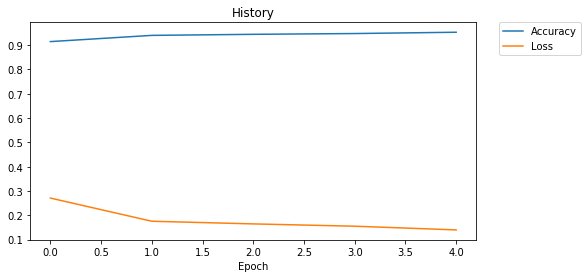

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['loss'], label="Loss")
plt.title("History")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Save Model

In [49]:
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# serialize model to JSON
model_json = model.to_json()
with open(os.path.join(MODEL_PATH, model_name + ".json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(MODEL_PATH, model_name + ".h5"))
print("Saved model to disk")

Saved model to disk
